<center><h2>Example 1: Calculate the potential energy surface </h2> </center> <br>
---
    
    
This notebook builds the potential energy surface (PES) of pairs of molecules along characteristic coordinates. N-dimensional scans can be performed and plotted to show the PES.<br>
<br>

 <i>Author</i>: <a href="https://github.com/oosode">Olaseni Sode</a> <br>
 <i>Created on</i>: June 1, 2018 <br>
 <i>Tags</i>: PES, electronic structure<br>

# Contents

---
   - [0. Load imports](#0.-Load-imports)
   - [1. Load dfk and functions](#1.-Load-dfk-and-functions)
   - [2. Choose molecules](#2.-Choose-molecules)
   - [3. Pick theory](#3.-Pick-theory)
   - [4. Optimize monomers](#4.-Optimize-monomers)
   - [5. Configure dimer](#5.-Configure-dimer)
   - [6. Optimize dimer](#6.-Optimize-dimer)
   - [7. Setup PES scan](#7.-Setup-scan)
   - [8. PES scan](#8.-PES-scan)
   - [9. Plot PES](#9.-Plot-PES)

## 0. Load imports

This cell imports the necessary modules. To execute a cell, click on it, then press <kbd>shift</kbd> + <kbd>enter</kbd>. (If you're new to the notebook environment, you may want to check out [this helpful cheat sheet](https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Notebook%20Basics.ipynb)).

In [1]:
import os
import sys
import gc
import py3Dmol


import ipywidgets as widgets
from subprocess import Popen, PIPE
from parsl import *
from math import *
from copy import *
from molecule import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cirpy

%matplotlib inline

#set plot sizes
#plt.rcParams['figure.figsize'] = (10, 20)  # (width, height)
#plt.rcParams['font.size'] = 20
#plt.rcParams['legend.fontsize'] = 16

## 1. Load dfk and functions

The following cells are used to load the data flow kernel need for parsl and the other necessary python functions needed to perform the potential energy surface scan. 

#### Load data flow kernel

In [2]:
from parsl.configs.local import localThreads

config = {
    "sites": [
        {
            "site": "midway_ipp_multicore",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    "taskBlocks": 1, # tasks per block
                    #"taskBlocks":20, 
                    "walltime": "00:05:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 10,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }, 
        {
            "site": "midway_ipp_singlenode",
            "auth": {
                "channel": "local",
                "hostname": "swift.rcc.uchicago.edu",
                "scriptDir": "/scratch/midway2/{0}/parsl_scripts".format('oosode')
            },
            "execution": {
                "executor": "ipp", # remote executor
                "provider": "slurm", 
                "block": {
                    "nodes": 1, # nodes per block
                    #"taskBlocks": 1, # tasks per block
                    "taskBlocks":20, 
                    "walltime": "00:15:00",
                    "initBlocks": 1,
                    "minBlocks" : 1,
                    "maxBlocks": 1,
                    "options": {'partition' : 'westmere',
                                'overrides' : 'source activate python36' }
                }
            }
        }
        
    ],
    "globals": {
        "lazyErrors": True,
    },
    #"controller" : {'publicIp' : ''}
}

#dfk = DataFlowKernel(config=config)
dfk = DataFlowKernel(config=localThreads)

#### Function to write electronic structure input files

In [3]:
def write_input(ID,mol,theory,basis,program,optimization,f12,cp):
    
    natoms=int(mol.natoms)
    
    if program=="MOLPRO":
        
        fout=open("%s.%06d.com"%("molpro",ID),"w")
        fout.write("***, %s %s \n"%(mol.name,optimization))
        fout.write("memory,100,M\n")
        fout.write("geometry={\n")
        
        for i in range(natoms):

            fout.write("%s%d "%(mol.atom[i],i))
            fout.write("%15.10f, %15.10f, %15.10f"%(mol.coord[i][0],\
                                                    mol.coord[i][1],\
                                                    mol.coord[i][2]))
            if i==natoms-1:
                fout.write("}\n")
            else:
                fout.write("\n")

        fout.write("basis=%s"%(basis))
        fout.write("\n")

        if cp:
            #This functionality doesn't exist yet.
            pass
        #    fout.write("text,cp calculation for %s %dmer_%i\n"%(name,m,n))
        #    fout.write("dummy,")
        #    for i in range(atoms):
        #        if molid[i] in dum:
        #            tmp=index*atoms
        #            fout.write("%s%d,"%(names[tmp+i],i))
        #            fout.write("\n")
        #        else:
        #            fout.write("text,calculation for %s %dmer\n"%(name,m))

        if theory!="hf":
            fout.write("hf\n")
            fout.write("%s"%(theory))
            if f12:
                fout.write("-f12\n")
            else:
                fout.write("\n")
        else:
            fout.write("hf\n")
            
        if optimization=="Minimum":
            fout.write("optg\n")
            fout.write("maxit=50\n")
        if optimization=="Saddle":
            fout.write("optg")

        fout.write("e_mer=energy\n")
        if (f12):
            fout.write("e_mer_F12a=energy(1)\n")
            fout.write("e_mer_F12b=energy(2)\n")
        fout.write("\n")
        fout.close()
        return
        
    if program=="NWChem":
        pass

#### Function to run electronic structure program

In [4]:
@App('bash', dfk)
def molpro(ID, outputs=[], stderr=None, stdout=None):
    #return "uname -a; /home/oosode/software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)
    return "uname -a; /Users/oosode/Software/molpro-2015/bin/molpro.exe  molpro.{0:06d}.com".format(ID)

#### Function to read electronic structure ouptut

In [5]:
def read_output(ID,program,mol):
    
    energy={}
    
    if program=="MOLPRO": 
        
        c=False
        fout="molpro.%06d.out"%(ID)
        if not os.path.isfile(fout):
            raiseIOError("No file for molpro.%06d.com"%(ID))

        else:
            fl=open(fout).readlines()

            for l in range(len(fl)-1,len(fl)-5,-1):
                if fl[l].find("Variable memory released")>=0:
                    c=True
                    break

            if (not c):
                energy[0]="inf"
                print("No energies for file molpro.%06d.com"%(ID))
                return

            else:
                for l,line in enumerate(fl):
                    if line.find("SETTING E_MER ")>=0: # energy
                        #print("hello")
                        energy['simple']=float(line.strip().split()[-2].replace("D","E"))
                    
                        mol.energy=energy
                        #print(mol['energy'])
                        
                    #if line.find("SETTING E_MER_F12A ")>=0: # F12a energy
                    #    energy['f12a']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    #elif line.find("SETTING E_MER_F12B ")>=0: # F12b energy
                    #    energy['f12b']=float(line.strip().split()[-2].replace("D","E"))
                    #    mol['energy']=energy
                    
                    elif line.find("END OF GEOMETRY OPTIMIZATION.")>=0:
                        natoms=int(fl[l+4].split()[0])
                        if natoms != mol.natoms:
                            print("There is a mismatch in the number of atoms")
                        for n in range(natoms):
                            for i in range(3):
                                mol.coord[n][i]=float(fl[l+6+n].split()[i+1])
                    
    return

#### Function to setup the PES scan.

In [6]:
def PES_scan(dim,variables,nCUP):
    
    # do pes scan
    sList = [] # list dimers to scan
    
    if nCUP==1:
        for m in range(len(variables)):
            
            var0=deepcopy(variables[m])
            
            for v0 in iter(deepcopy(var0)):
                
                tmp=deepcopy(dim) # copy dimer
                tmp.setup_dimer() 
                tmp.transform_dimer(v0,var0.name,var0.molID)
                tmp.set_dimer()
                sList.append(tmp)
                
    elif nCUP==2:
        for m in range(len(variables)):
            for n in range(m,len(variables)):
                
                var0=deepcopy(variables[m])
                var1=deepcopy(variables[n])
                
                for v0 in iter(var0):
                    for v1 in iter(var1):
                        
                        tmp=deepcopy(dim) # copy dimer
                        tmp.setup_dimer() 
                        tmp.transform_dimer(v0,var0.name,var0.molID)
                        tmp.transform_dimer(v1,var1.name,var1.molID)
                        tmp.set_dimer()
                        sList.append(tmp)
    
    else:
        print("The coupling between variables (ncup) must be set to either 0 or 1.")
                
    print(len(sList))      
    return sList

#### Class that defines the different variables.

In [7]:
class Var:
    def __init__(self,name,minimum,maximum,inc,unit,mID=1):
        self.name=name
        self.min=minimum
        self.max=maximum
        self.inc=inc
        self.unit=unit
        self.molID=mID
        self.current=self.min
        return
        
    def determine_range(self):
        x=self.min
        tmp=[]
        while x<=self.max:
            tmp.append(x)
            x+=self.inc
        self.ranges=tuple(tmp)
        return
    
    def __iter__(self):
        return self

    def __next__(self):
        if self.current > self.max:
            raise StopIteration
        else:
            self.current += self.inc
            return self.current - self.inc
        

## 2. Choose molecules

The cells below allows you to pick the two types of molecules for the PES scan. It uses the cirpy module to resolve the name of the molecules and then loads the xyz coordinates and atom names into the `molecule` class. This class then configures the remaining values including atomic mass, number of atoms, etc. 

**NOTE:** You can change the molecule types from the default "carbon dioxide" to any other molecule in the chemical information resolver database. Just change the name below.

In [8]:
mol0 = molecule("CO2",1) # name and number of molecules
mol0.resolve()

mol1 = molecule("H2O",1)
mol1.resolve()

mList = (mol0,mol1)

Intialized new molecule class: CO2
Resolved chemical identification of CO2
Intialized new molecule class: H2O
Resolved chemical identification of H2O


In [9]:
view0 = py3Dmol.view(width=1000,height=400,linked=False,viewergrid=(1,2))
#view0.removeAllModels(viewer=(0,0))
view0.addModel(mol0.xyz(),'xyz',viewer=(0,0))
view0.addModel(mol1.xyz(),'xyz',viewer=(0,1))
view0.setStyle({'sphere':{}})
view0.setBackgroundColor('0xeeeeee')
view0.zoomTo(viewer=(0,0))
#view0.render()
view0.show()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3. Pick theory

The cells below allows you to choose the level of electronic structure theory, the basis set, the use of explicit correlation and the electronic structure program. (Currently, only the MOLPRO software package is implemented.) 

Some configurations of theory, basis set and programs are not possible. Once you have selected your program variables, make sure to check the configurations availability with the `wrapper.check()` function.


In [10]:
theory="HF"
basis="aug-cc-pVDZ"
f12=False
program="MOLPRO"

## 4. Optimize monomers

You can optimize the two monomers in the cells below. In the first cell, the input files are written. The second cell submits the input files and waits for them to finish. The last cell parses the output file and recovers the data. When running jobs on a compute cluster, the status of the job can be checked using the `qstat` command. The final energy and cartesian coordinates of the geometry are printed. 

**Write input files**:

In [11]:
for ID in range(2):
    write_input(ID,mList[ID],theory,basis,program,"Minimum",f12,False)


**Run calculations**:

In [12]:
for ID in range(2):
    #run_input(ID,program)
    fut = molpro(ID, outputs=["molpro.%06d.out"%(ID), "molpro.%06d.xml"%(ID)],
                     stdout="molpro.%06d.stdout"%(ID),
                     stderr="molpro.%06d.stderr"%(ID))

**Check status**:

In [15]:
#!qstat -u $USER
!ls -lt | head -10
!tail molpro.000000.out

total 5336
-rw-r--r--  1 oosode  staff   39757 Jun 13 10:50 molpro.000000.log
-rw-r--r--  1 oosode  staff   17326 Jun 13 10:50 molpro.000000.out
-rw-r--r--  1 oosode  staff   26895 Jun 13 10:50 molpro.000000.xml
-rw-r--r--  1 oosode  staff   45466 Jun 13 10:50 molpro.000001.log
-rw-r--r--  1 oosode  staff   16163 Jun 13 10:50 molpro.000001.out
-rw-r--r--  1 oosode  staff   27507 Jun 13 10:50 molpro.000001.xml
-rw-r--r--  1 oosode  staff       0 Jun 13 10:49 molpro.000000.stderr
-rw-r--r--  1 oosode  staff     136 Jun 13 10:49 molpro.000000.stdout
-rw-r--r--  1 oosode  staff       0 Jun 13 10:49 molpro.000001.stderr
 **********************************************************************************************************************************
 SETTING MAXIT          =        50.00000000                                  
 SETTING E_MER          =      -187.66435757  AU                              

 HF/aug-cc-pVDZ//HF/aug-cc-pVDZ energy=   -187.664357568173

        OPTG(HF)        H

**Read output**:

In [16]:
for ID in range(2):
    read_output(ID,program,mList[ID])

## 5. Configure dimer position

Once the isolated monomers are obtained (and optimized), the next step is to orient them with respect to one another. This is done using a spherical coordinate space, shown below. The __orientation of molecule 1__ and the __orientation of molecule 2__ are determined first, followed by the __position__ of molecule 2 relative to molecule 1. 

Molecule 1 is always placed at the origin (0,0,0) oriented in space with $\theta_1$ and $\phi_1$. The range of $\theta_1$ is [0°, 180°] and the range of $\phi_1$ is [0, 360°). Molecule 2 is placed using spherical coordinates at some distance R from the origin, with $\theta_d$ and $\phi_d$ ranging from [0°, 180°] and [0, 360°), respectively. The orientation of Molecule 2 is denoted by $\theta_2$ and $\phi_2$ values. All angles are in degree units and distances are in angstroms.

<img src='https://upload.wikimedia.org/wikipedia/commons/4/4f/3D_Spherical.svg' style="width: 300px;">

#### Orientation of molecule 1

In [17]:
theta_0 = 0
phi_0 = 0

#### Orientation of molecule 2

In [18]:
theta_1 = 0
phi_1 = 0

In [19]:
tList = (theta_0,theta_1)
pList = (phi_0,phi_1)

#### Position

In [20]:
R = 4.0
theta_d = 90
phi_d = -90

#### Orient dimer

In [21]:
for i,m in enumerate(mList):
    m.calculate_com()
    m.center()
    m.rotate_theta(tList[i],0)
    m.rotate_phi(pList[i],0)

dimer=molecule("whatever",1)
dimer.init_dimer(mList[0],mList[1])
dimer.position(R,theta_d,phi_d)
dimer.calculate_vector()

Intialized new molecule class: whatever


#### Show dimer

In [24]:
view1 = py3Dmol.view(width=1000,height=700)
view1.addModel(dimer.xyz(),'xyz')
view1.setStyle({'stick':{}})
view1.setBackgroundColor('0xeeeeee')
view1.show()

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 6. Optimize dimer structure

The dimer structure can be optimized such that any potential energy scan originates from either a global or local minimum, or a saddle point. To optimize to a minimum, set the optimization flag to `Minimum`, and to optimize to a saddle point, set the optimization variable to `Saddle`. If you prefer not to optimize the dimer further, specify `None`.



In [25]:
optimization="None"

In [26]:
if optimization=="None":
    pass

elif optimization=="Minimum" or "Saddle":
    write_input(3,dim,theory,basis,program,optimization,f12,False)
    fut = molpro(3, outputs=["molpro.%06d.out"%(3), "molpro.%06d.xml"%(3)],
                     stdout="molpro.%06d.stdout"%(3),
                     stderr="molpro.%06d.stderr"%(3))
    read_output(3,program)
    
else:
    raise IOError("Unknown optimization.")

## 7. Setup scan

The potential energy surface will be scanned along some characteristic coordinate(s). There is no limit to the number coordinates to scan however, the maximum coupling between coordinates is 2. Some examples of coordinates include the 'R' distance, the $\phi_1$ angle or the $\theta_d$ angle. For each coordinate, the range of values and the increment must be specified. Increments for distances are in angstroms and are in degrees for angles. 

**Which variables?**

In [27]:
variables=[]

Rname = 'translation'
Rmini = 2.0
Rmaxi = 8.0
Rincr = 0.1
Runit = 'angstrom'

var1=Var(Rname,Rmini,Rmaxi,Rincr,Runit,1)
var1.determine_range()
variables.append(var1)

#tname = 'theta'
#tmini = -90.0
#tmaxi =  90.0
#tincr =  10.0
#tunit = 'degrees'
#tID = 0

#var2=Var(tname,tmini,tmaxi,tincr,tunit,tID)
#variables.append(var2)

**number of variable coupling?**

In [28]:
nCUP=1

## 8. PES scan

Once the scan variables are determined, proceed through the next cells to perform electronic structure calculations on each of the dimer configurations.

#### Determine dimer configurations

This also prints the number of configurations to evaluate.

In [29]:
dimer_scans=PES_scan(dimer,variables,nCUP)

61


In [33]:
print(dimer_scans[0].coord)

[[-1.1418296019, 8.899802609288219e-17, 1.9081127735955607e-17], [1.1418296019, -5.083577062097098e-17, 1.9081127735955607e-17], [0.0, -5.083577062097098e-17, -5.083577062097098e-17], [-0.7532755405, -1.4952579589594226, 1.4773336712303596e-16], [0.7532755405, -1.4952579589594226, 1.4773336712303596e-16], [1.3217054322269104e-16, -2.063596096459422, 9.610531683603202e-17]]


#### Write scan input files

In [34]:
for k,dscan in enumerate(dimer_scans): # loop over monomers
    write_input(k+3,dscan,theory,basis,program,"None",f12,False)

#### Run calculations

In [35]:
for k in range(len(dimer_scans)):
    #run_input(k+3,program)
    fut = molpro(k+3, outputs=["molpro.%06d.out"%(k+3), "molpro.%06d.xml"%(k+3)],
                     stdout="molpro.%06d.stdout"%(k+3),
                     stderr="molpro.%06d.stderr"%(k+3))

In [43]:
#!qstat -u $USER
! ls -lt | head -10

total 10248
-rw-r--r--  1 oosode  staff   52875 Jun 13 10:54 pes-2b.ipynb
-rw-r--r--  1 oosode  staff   14403 Jun 13 10:54 molpro.000063.out
-rw-r--r--  1 oosode  staff   18573 Jun 13 10:54 molpro.000063.xml
-rw-r--r--  1 oosode  staff   14403 Jun 13 10:54 molpro.000062.out
-rw-r--r--  1 oosode  staff   18572 Jun 13 10:54 molpro.000062.xml
-rw-r--r--  1 oosode  staff   14403 Jun 13 10:54 molpro.000060.out
-rw-r--r--  1 oosode  staff   18572 Jun 13 10:54 molpro.000060.xml
-rw-r--r--  1 oosode  staff   14403 Jun 13 10:54 molpro.000061.out
-rw-r--r--  1 oosode  staff   18571 Jun 13 10:54 molpro.000061.xml


#### Read outputs and collect energies

In [44]:
x=[]
nrg=[]
for k,dscan in enumerate(dimer_scans): # loop over dimers
    read_output(k+3,program,dscan)
    nrg.append(dscan.energy['simple'])


## 9. Plot PES



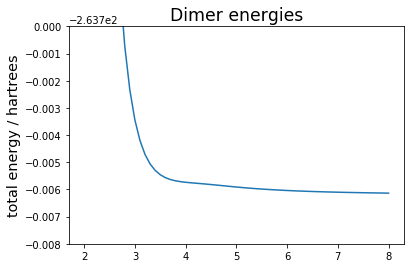

In [45]:
%matplotlib inline
plt.figure()
plt.title("Dimer energies", size='xx-large')
plt.ylabel("total energy / hartrees", size='x-large')
plt.ylim([-263.708,-263.70])
plt.plot(variables[0].ranges,nrg)